# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_clustereasy_singlebatch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Jul25-1328'

In [4]:
state_key = 'cluster'
batch_key = 'batch'
state_type = 'cluster'
leiden_key='leiden'
batch_type = 'batch_specific_features'
distribution = 'normal'
concord_methods = ['concord_hcl', 'concord_knn']
other_methods = [
    "PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
    "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
    "contrastive"
]
run_methods = concord_methods + other_methods
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]

In [9]:
from concord.simulation import (
    SimConfig, ClusterConfig, BatchConfig, Simulation
)

# ──────────────── Inputs ────────────────
seed = 42
n_cells = [100,100,50]
n_genes = [1000,1000,500]
state_dispersion = [4.0, 2.0, 2.0]

# ─────────────── SimConfig ───────────────
sim_cfg = SimConfig(
    n_cells=n_cells,
    n_genes=n_genes,
    seed=seed,
    non_neg=True,
    to_int=True,
)

# ─────────────── ClusterConfig ───────────────
state_cfg = ClusterConfig(
    n_states=3,
    distribution="normal",
    level=5.0,
    min_level=0.0,
    dispersion=state_dispersion,
    program_structure="uniform",
    program_on_time_fraction=0.3,
    global_non_specific_gene_fraction=0.1,
    pairwise_non_specific_gene_fraction=None,
)

# ─────────────── BatchConfig ───────────────
batch_cfg = BatchConfig(
    n_batches=1,
    effect_type="batch_specific_features",
    distribution="normal",
    level=[5.0],              # One value for 1 batch
    dispersion=[3.0],
    feature_frac=0.15,
)

# ─────────────── Simulation ───────────────
sim = Simulation(sim_cfg, state_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()
adata.layers["counts"] = adata.X.copy()


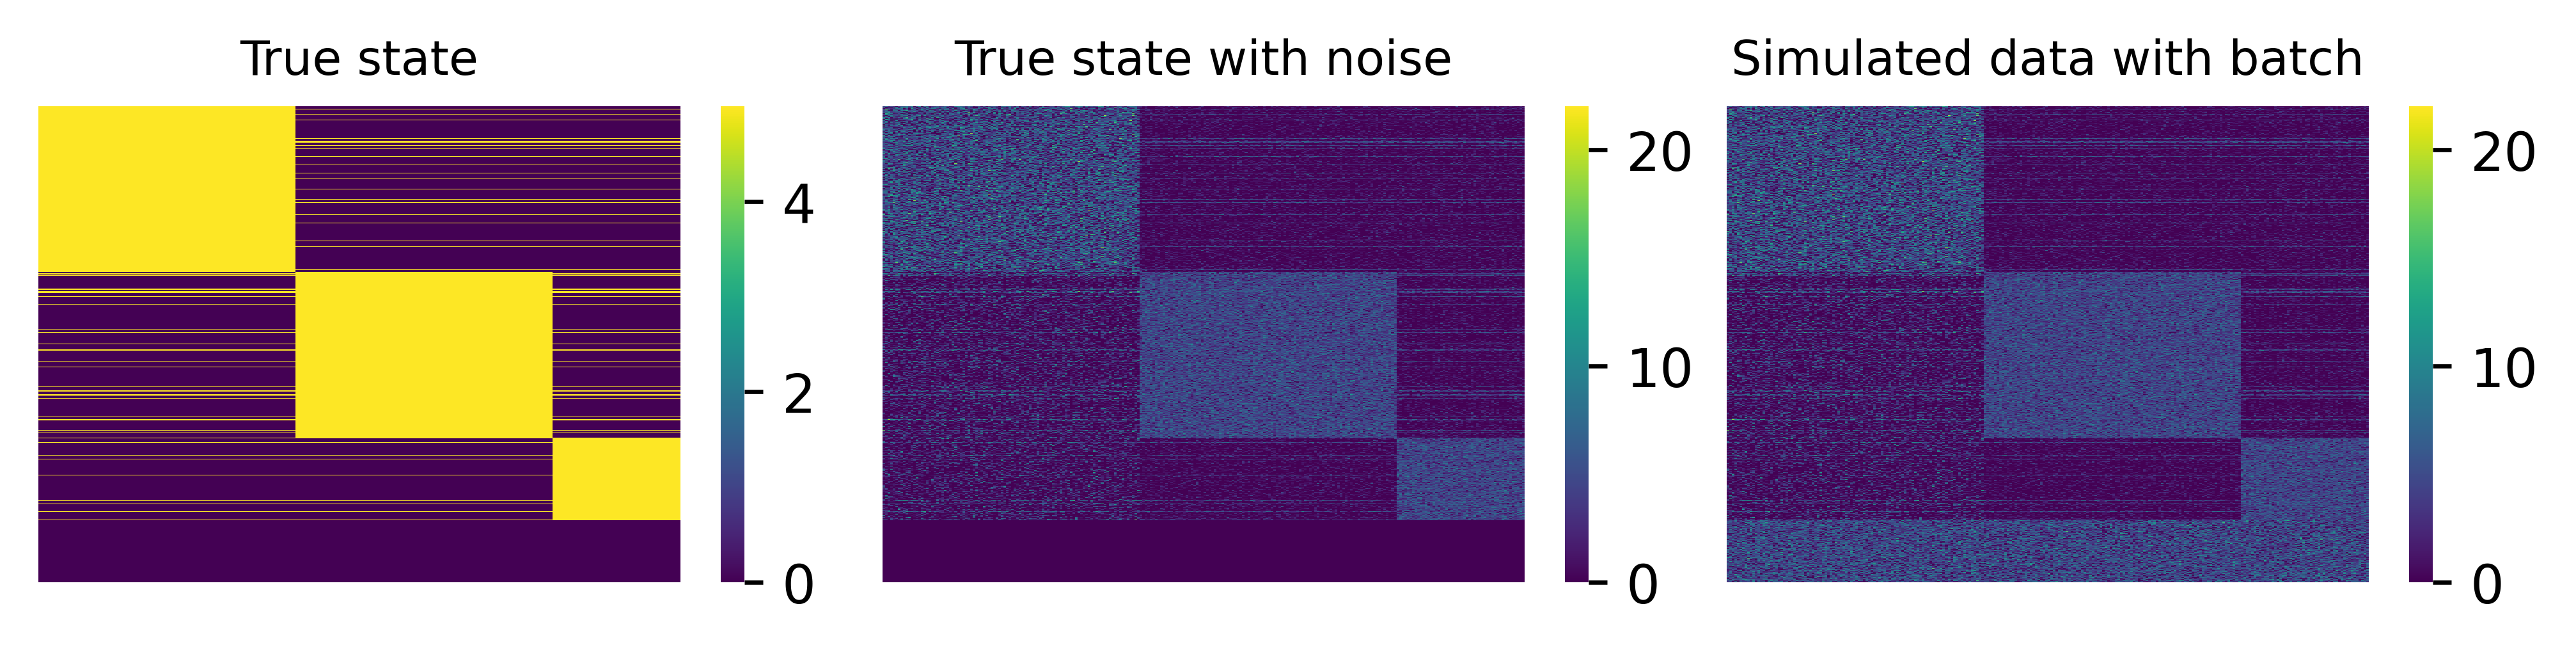

In [8]:
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 3
title_fontsize = 9
dpi = 600
_, _, state_pal = ccd.pl.get_color_mapping(adata, state_key, pal='Paired', seed=seed)
_, _, batch_pal = ccd.pl.get_color_mapping(adata, batch_key, pal='Set1', seed=seed)
pal = {state_key: state_pal, batch_key: batch_pal}
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
for ax, (val, title) in zip(
        axes,
        [('no_noise', 'True state'),
         ('wt_noise', 'True state with noise'),
         ('X',        'Simulated data with batch')]):

    ccd.pl.heatmap_with_annotations(
        adata,
        val=val,
        obs_keys=[state_key] if val != 'X' else [state_key, batch_key],
        pal=pal,
        use_clustermap=False,        # plain heat‑map
        cluster_rows=False,
        cluster_cols=False,
        yticklabels=False,
        value_annot=False,
        cmap='viridis',
        title=title,
        title_fontsize=9,
        ax=ax,
        show=False                   # don’t flush the figure yet
    )

plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"data_heatmaps_{file_suffix}.svg",
            dpi=600, bbox_inches='tight')
plt.show()

### Run dimension reduction

In [ ]:
n_components = 15
ccd.ul.run_pca(adata, source_key='no_noise', result_key='PCA_no_noise', n_pc=n_components, random_state=seed)
ccd.ul.run_umap(adata, source_key='no_noise', result_key='UMAP_no_noise', random_state=seed)
sc.pp.neighbors(adata, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)

adata.obsm['no_noise'] = adata.layers['no_noise']
adata.obsm['wt_noise'] = adata.layers['wt_noise']

concord - INFO - PCA performed on source data with 15 components
concord - INFO - PCA embedding stored in adata.obsm['PCA_no_noise']


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


concord - INFO - UMAP embedding stored in adata.obsm['UMAP_no_noise']


In [18]:
concord_kwargs = {
    'batch_size': 64,
    'n_epochs': 10,
    'load_data_into_memory': True,
    'verbose': False,
}
latent_dim = 15

In [ ]:
bench_res = ccd.bm.run_dimensionality_reduction_pipeline(
    adata,
    source_key="X",
    methods=run_methods,
    n_components=latent_dim,
    seed=seed,
    device=device,
    save_dir=save_dir,
    concord_kwargs=concord_kwargs,
)

concord - INFO - PCA performed on source data with 15 components
concord - INFO - PCA embedding stored in adata.obsm['PCA']
concord.benchmarking.benchmark - INFO - PCA: 0.02s | 0.08 MB RAM | 0.00 MB VRAM
concord - INFO - UMAP embedding stored in adata.obsm['UMAP']
concord.benchmarking.benchmark - INFO - UMAP: 0.25s | 0.02 MB RAM | 0.00 MB VRAM
concord - INFO - T-SNE embedding stored in adata.obsm['tSNE']
concord.benchmarking.benchmark - INFO - t-SNE: 0.72s | 168.98 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - DiffusionMap: 0.02s | 0.27 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - NMF: 0.20s | 0.14 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - FactorAnalysis: 0.06s | 11.41 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - FastICA: 0.04s | 0.34 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - LDA: 13.67s | 0.02 MB RAM | 0.00 MB VRAM
Running zero-inflated factor analysis with N = 250, D = 2875, K = 15
Param change 

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


concord.benchmarking.benchmark - INFO - scVI: 12.60s | 176.44 MB RAM | 0.00 MB VRAM
Calculating PHATE...
  Running PHATE on 250 observations and 2875 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.16 seconds.
    Calculating KNN search...
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.21 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculated optimal t in 0.02 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.03 seconds.
Calculated PHATE in 0.27 seconds.
concord.benchmarking.benchmark - INFO - PHATE: 0.33s | 1.31 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - Running concord_knn with configuration: {'mode': 'default', 'extra_kwargs': {'p_intra_knn': 0.3, 'clr_beta': 0.0}}
concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
co

Epoch 0 Training: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, loss=4.681]

concord - INFO - Epoch   0 | Train Loss: 4.76, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.76, IMPORTANCE: 0.00
concord - INFO - Starting epoch 2/15
concord - INFO - Processing chunk 1/1 for epoch 2
concord - INFO - Number of samples in train_dataloader: 250



Epoch 1 Training: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=4.152]

concord - INFO - Epoch   1 | Train Loss: 4.32, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.32, IMPORTANCE: 0.00
concord - INFO - Starting epoch 3/15
concord - INFO - Warm-up complete. Computing k-NN graph on learned embeddings.
concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 250 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 250 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord.model.dataloader - INFO - Computing k-NN graph using embedding from 'X_concord_warmup'...
concord - INFO - Using euclidean distance metric.
concord - WARNING - FAISS not found. Using sklearn for k-NN computation.
concord - INFO - Processing chunk 1/1 for epoch 3
concord - INFO - Number of samples in train_dataloader: 250


Epoch 2 Training: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=3.931]

concord - INFO - Epoch   2 | Train Loss: 3.96, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.96, IMPORTANCE: 0.00
concord - INFO - Starting epoch 4/15
concord - INFO - Processing chunk 1/1 for epoch 4
concord - INFO - Number of samples in train_dataloader: 250



Epoch 3 Training: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=3.861]

concord - INFO - Epoch   3 | Train Loss: 3.87, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.87, IMPORTANCE: 0.00
concord - INFO - Starting epoch 5/15
concord - INFO - Processing chunk 1/1 for epoch 5
concord - INFO - Number of samples in train_dataloader: 250



Epoch 4 Training: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s, loss=3.945]

concord - INFO - Epoch   4 | Train Loss: 3.94, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.94, IMPORTANCE: 0.00
concord - INFO - Starting epoch 6/15
concord - INFO - Processing chunk 1/1 for epoch 6
concord - INFO - Number of samples in train_dataloader: 250



Epoch 5 Training: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=3.832]

concord - INFO - Epoch   5 | Train Loss: 3.87, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.87, IMPORTANCE: 0.00
concord - INFO - Starting epoch 7/15
concord - INFO - Processing chunk 1/1 for epoch 7
concord - INFO - Number of samples in train_dataloader: 250



Epoch 6 Training: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=3.955]

concord - INFO - Epoch   6 | Train Loss: 3.91, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.91, IMPORTANCE: 0.00
concord - INFO - Starting epoch 8/15
concord - INFO - Processing chunk 1/1 for epoch 8
concord - INFO - Number of samples in train_dataloader: 250



Epoch 7 Training: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s, loss=3.916]

concord - INFO - Epoch   7 | Train Loss: 3.92, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.92, IMPORTANCE: 0.00
concord - INFO - Starting epoch 9/15
concord - INFO - Processing chunk 1/1 for epoch 9
concord - INFO - Number of samples in train_dataloader: 250



Epoch 8 Training: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=3.786]

concord - INFO - Epoch   8 | Train Loss: 3.84, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.84, IMPORTANCE: 0.00
concord - INFO - Starting epoch 10/15
concord - INFO - Processing chunk 1/1 for epoch 10
concord - INFO - Number of samples in train_dataloader: 250



Epoch 9 Training: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=3.931]

concord - INFO - Epoch   9 | Train Loss: 3.92, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.92, IMPORTANCE: 0.00
concord - INFO - Starting epoch 11/15
concord - INFO - Processing chunk 1/1 for epoch 11
concord - INFO - Number of samples in train_dataloader: 250



Epoch 10 Training: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s, loss=3.874]

concord - INFO - Epoch  10 | Train Loss: 3.89, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.89, IMPORTANCE: 0.00
concord - INFO - Starting epoch 12/15
concord - INFO - Processing chunk 1/1 for epoch 12
concord - INFO - Number of samples in train_dataloader: 250



Epoch 11 Training: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s, loss=3.813]

concord - INFO - Epoch  11 | Train Loss: 3.85, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.85, IMPORTANCE: 0.00
concord - INFO - Starting epoch 13/15
concord - INFO - Processing chunk 1/1 for epoch 13
concord - INFO - Number of samples in train_dataloader: 250



Epoch 12 Training: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=3.892]

concord - INFO - Epoch  12 | Train Loss: 3.91, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.91, IMPORTANCE: 0.00
concord - INFO - Starting epoch 14/15
concord - INFO - Processing chunk 1/1 for epoch 14
concord - INFO - Number of samples in train_dataloader: 250



Epoch 13 Training: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=3.910]

concord - INFO - Epoch  13 | Train Loss: 3.86, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.86, IMPORTANCE: 0.00
concord - INFO - Starting epoch 15/15
concord - INFO - Processing chunk 1/1 for epoch 15
concord - INFO - Number of samples in train_dataloader: 250



Epoch 14 Training: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s, loss=3.930]

concord - INFO - Epoch  14 | Train Loss: 3.91, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.91, IMPORTANCE: 0.00
concord - WARNING - save_dir is None. Skipping model/config saving.
concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 250 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord - INFO - Predictions added to AnnData object with base key 'concord_knn'.
concord.benchmarking.benchmark - INFO - concord_knn: 42.82s | 0.00 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - Running concord_hcl with configuration: {'mode': 'default', 'extra_kwargs': {'p_intra_knn': 0.0, 'clr_beta': 1.0}}
concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - INFO - Using NT-Xent loss with beta=1.0. This will apply hard-negative weighting to the contrastive loss.
concord - INFO - HCL (Contrastive learning with hard negative samples) mode is enabled.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `con

Epoch 0 Training: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=4.754]

concord - INFO - Epoch   0 | Train Loss: 4.85, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.85, IMPORTANCE: 0.00
concord - INFO - Starting epoch 2/15
concord - INFO - Processing chunk 1/1 for epoch 2
concord - INFO - Number of samples in train_dataloader: 250



Epoch 1 Training: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=4.577]

concord - INFO - Epoch   1 | Train Loss: 4.62, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.62, IMPORTANCE: 0.00
concord - INFO - Starting epoch 3/15
concord - INFO - Processing chunk 1/1 for epoch 3
concord - INFO - Number of samples in train_dataloader: 250



Epoch 2 Training: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=4.545]

concord - INFO - Epoch   2 | Train Loss: 4.56, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.56, IMPORTANCE: 0.00
concord - INFO - Starting epoch 4/15
concord - INFO - Processing chunk 1/1 for epoch 4
concord - INFO - Number of samples in train_dataloader: 250



Epoch 3 Training: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=4.558]

concord - INFO - Epoch   3 | Train Loss: 4.55, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.55, IMPORTANCE: 0.00
concord - INFO - Starting epoch 5/15
concord - INFO - Processing chunk 1/1 for epoch 5
concord - INFO - Number of samples in train_dataloader: 250



Epoch 4 Training: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=4.590]

concord - INFO - Epoch   4 | Train Loss: 4.56, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.56, IMPORTANCE: 0.00
concord - INFO - Starting epoch 6/15
concord - INFO - Processing chunk 1/1 for epoch 6
concord - INFO - Number of samples in train_dataloader: 250



Epoch 5 Training: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=4.544]

concord - INFO - Epoch   5 | Train Loss: 4.54, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.54, IMPORTANCE: 0.00
concord - INFO - Starting epoch 7/15
concord - INFO - Processing chunk 1/1 for epoch 7
concord - INFO - Number of samples in train_dataloader: 250



Epoch 6 Training: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=4.547]

concord - INFO - Epoch   6 | Train Loss: 4.55, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.55, IMPORTANCE: 0.00
concord - INFO - Starting epoch 8/15
concord - INFO - Processing chunk 1/1 for epoch 8
concord - INFO - Number of samples in train_dataloader: 250



Epoch 7 Training: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s, loss=4.558]

concord - INFO - Epoch   7 | Train Loss: 4.55, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.55, IMPORTANCE: 0.00
concord - INFO - Starting epoch 9/15
concord - INFO - Processing chunk 1/1 for epoch 9
concord - INFO - Number of samples in train_dataloader: 250



Epoch 8 Training: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=4.552]

concord - INFO - Epoch   8 | Train Loss: 4.55, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.55, IMPORTANCE: 0.00
concord - INFO - Starting epoch 10/15
concord - INFO - Processing chunk 1/1 for epoch 10
concord - INFO - Number of samples in train_dataloader: 250



Epoch 9 Training: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=4.543]

concord - INFO - Epoch   9 | Train Loss: 4.54, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.54, IMPORTANCE: 0.00
concord - INFO - Starting epoch 11/15
concord - INFO - Processing chunk 1/1 for epoch 11
concord - INFO - Number of samples in train_dataloader: 250



Epoch 10 Training: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s, loss=4.539]

concord - INFO - Epoch  10 | Train Loss: 4.55, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.55, IMPORTANCE: 0.00
concord - INFO - Starting epoch 12/15
concord - INFO - Processing chunk 1/1 for epoch 12
concord - INFO - Number of samples in train_dataloader: 250



Epoch 11 Training: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=4.539]

concord - INFO - Epoch  11 | Train Loss: 4.55, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.55, IMPORTANCE: 0.00
concord - INFO - Starting epoch 13/15
concord - INFO - Processing chunk 1/1 for epoch 13
concord - INFO - Number of samples in train_dataloader: 250



Epoch 12 Training: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=4.554]

concord - INFO - Epoch  12 | Train Loss: 4.54, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.54, IMPORTANCE: 0.00
concord - INFO - Starting epoch 14/15
concord - INFO - Processing chunk 1/1 for epoch 14
concord - INFO - Number of samples in train_dataloader: 250



Epoch 13 Training: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=4.543]

concord - INFO - Epoch  13 | Train Loss: 4.54, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.54, IMPORTANCE: 0.00
concord - INFO - Starting epoch 15/15
concord - INFO - Processing chunk 1/1 for epoch 15
concord - INFO - Number of samples in train_dataloader: 250



Epoch 14 Training: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=4.531]

concord - INFO - Epoch  14 | Train Loss: 4.54, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.54, IMPORTANCE: 0.00
concord - WARNING - save_dir is None. Skipping model/config saving.
concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 250 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord - INFO - Predictions added to AnnData object with base key 'concord_hcl'.
concord.benchmarking.benchmark - INFO - concord_hcl: 38.96s | 0.00 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - WARNING - Skipping concord_class as it is not in the methods list.
concord.benchmarking.benchmark - WARNING - Skipping concord_decoder as it is not in the methods list.
concord.benchmarking.benchmark - INFO - Running contrastive with configuration: {'mode': 'naive', 'extra_kwargs': {'p_intra_knn': 0.0, 'clr_beta': 0.0}}
concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord

Epoch 0 Training: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=4.681]

concord - INFO - Epoch   0 | Train Loss: 4.76, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.76, IMPORTANCE: 0.00
concord - INFO - Starting epoch 2/15
concord - INFO - Processing chunk 1/1 for epoch 2
concord - INFO - Number of samples in train_dataloader: 250



Epoch 1 Training: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=4.152]

concord - INFO - Epoch   1 | Train Loss: 4.32, MSE: 0.00, CLASS: 0.00, CONTRAST: 4.32, IMPORTANCE: 0.00
concord - INFO - Starting epoch 3/15
concord - INFO - Processing chunk 1/1 for epoch 3
concord - INFO - Number of samples in train_dataloader: 250



Epoch 2 Training: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=3.921]

concord - INFO - Epoch   2 | Train Loss: 3.98, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.98, IMPORTANCE: 0.00
concord - INFO - Starting epoch 4/15
concord - INFO - Processing chunk 1/1 for epoch 4
concord - INFO - Number of samples in train_dataloader: 250



Epoch 3 Training: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=3.956]

concord - INFO - Epoch   3 | Train Loss: 3.93, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.93, IMPORTANCE: 0.00
concord - INFO - Starting epoch 5/15
concord - INFO - Processing chunk 1/1 for epoch 5
concord - INFO - Number of samples in train_dataloader: 250



Epoch 4 Training: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=4.038]

concord - INFO - Epoch   4 | Train Loss: 3.93, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.93, IMPORTANCE: 0.00
concord - INFO - Starting epoch 6/15
concord - INFO - Processing chunk 1/1 for epoch 6
concord - INFO - Number of samples in train_dataloader: 250



Epoch 5 Training: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=3.915]

concord - INFO - Epoch   5 | Train Loss: 3.90, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.90, IMPORTANCE: 0.00
concord - INFO - Starting epoch 7/15
concord - INFO - Processing chunk 1/1 for epoch 7
concord - INFO - Number of samples in train_dataloader: 250



Epoch 6 Training: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=3.914]

concord - INFO - Epoch   6 | Train Loss: 3.92, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.92, IMPORTANCE: 0.00
concord - INFO - Starting epoch 8/15
concord - INFO - Processing chunk 1/1 for epoch 8
concord - INFO - Number of samples in train_dataloader: 250



Epoch 7 Training: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s, loss=3.960]

concord - INFO - Epoch   7 | Train Loss: 3.92, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.92, IMPORTANCE: 0.00
concord - INFO - Starting epoch 9/15
concord - INFO - Processing chunk 1/1 for epoch 9
concord - INFO - Number of samples in train_dataloader: 250



Epoch 8 Training: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=3.937]

concord - INFO - Epoch   8 | Train Loss: 3.92, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.92, IMPORTANCE: 0.00
concord - INFO - Starting epoch 10/15
concord - INFO - Processing chunk 1/1 for epoch 10
concord - INFO - Number of samples in train_dataloader: 250



Epoch 9 Training: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=3.904]

concord - INFO - Epoch   9 | Train Loss: 3.89, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.89, IMPORTANCE: 0.00
concord - INFO - Starting epoch 11/15
concord - INFO - Processing chunk 1/1 for epoch 11
concord - INFO - Number of samples in train_dataloader: 250



Epoch 10 Training: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=3.891]

concord - INFO - Epoch  10 | Train Loss: 3.92, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.92, IMPORTANCE: 0.00
concord - INFO - Starting epoch 12/15
concord - INFO - Processing chunk 1/1 for epoch 12
concord - INFO - Number of samples in train_dataloader: 250



Epoch 11 Training: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=3.893]

concord - INFO - Epoch  11 | Train Loss: 3.92, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.92, IMPORTANCE: 0.00
concord - INFO - Starting epoch 13/15
concord - INFO - Processing chunk 1/1 for epoch 13
concord - INFO - Number of samples in train_dataloader: 250



Epoch 12 Training: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=3.936]

concord - INFO - Epoch  12 | Train Loss: 3.90, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.90, IMPORTANCE: 0.00
concord - INFO - Starting epoch 14/15
concord - INFO - Processing chunk 1/1 for epoch 14
concord - INFO - Number of samples in train_dataloader: 250



Epoch 13 Training: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=3.894]

concord - INFO - Epoch  13 | Train Loss: 3.88, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.88, IMPORTANCE: 0.00
concord - INFO - Starting epoch 15/15
concord - INFO - Processing chunk 1/1 for epoch 15
concord - INFO - Number of samples in train_dataloader: 250



Epoch 14 Training: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=3.857]

concord - INFO - Epoch  14 | Train Loss: 3.89, MSE: 0.00, CLASS: 0.00, CONTRAST: 3.89, IMPORTANCE: 0.00
concord - WARNING - save_dir is None. Skipping model/config saving.
concord.model.dataloader - INFO - Using 1 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 250 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord - INFO - Predictions added to AnnData object with base key 'contrastive'.
concord.benchmarking.benchmark - INFO - contrastive: 38.64s | 3.81 MB RAM | 0.00 MB VRAM
concord.benchmarking.benchmark - INFO - 📝 Time log saved to ../save/dev_simulation_clustereasy_singlebatch-Jul18/dimensionality_reduction_timelog.json


In [15]:
# Run umap and PCA for all latent embeddings
for basis in combined_keys:
    print("Running UMAP and PCA for", basis)
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
    if not any(substring in basis for substring in ['PHATE', 'PCA']):
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=latent_dim, random_state=seed)


Running UMAP and PCA for no_noise
Running UMAP and PCA for wt_noise
Running UMAP and PCA for concord_hcl
Running UMAP and PCA for concord_knn
Running UMAP and PCA for DiffusionMap
Running UMAP and PCA for NMF
Running UMAP and PCA for FactorAnalysis
Running UMAP and PCA for FastICA
Running UMAP and PCA for LDA
Running UMAP and PCA for ZIFA
Running UMAP and PCA for scVI
Running UMAP and PCA for PHATE
Running UMAP and PCA for contrastive


In [ ]:
# Save the pandas DataFrame with the results
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
print("Data saved to", data_dir / f"adata_{file_suffix}.h5ad")
bench_res.to_csv(save_dir / f"benchmark_results_{file_suffix}.csv", index=False)
print("Benchmark results saved to", save_dir / f"benchmark_results_{file_suffix}.csv")

Benchmark results saved to ../save/dev_simulation_clustereasy_singlebatch-Jul18/benchmark_results_Jul18-1454.csv


concord.plotting.pl_embedding - INFO - Plotting no_noise with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting wt_noise with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting DiffusionMap with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting NMF with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting FactorAnalysis with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting FastICA with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting LDA with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting ZIFA with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting scVI with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting PHATE with cluster in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with clust

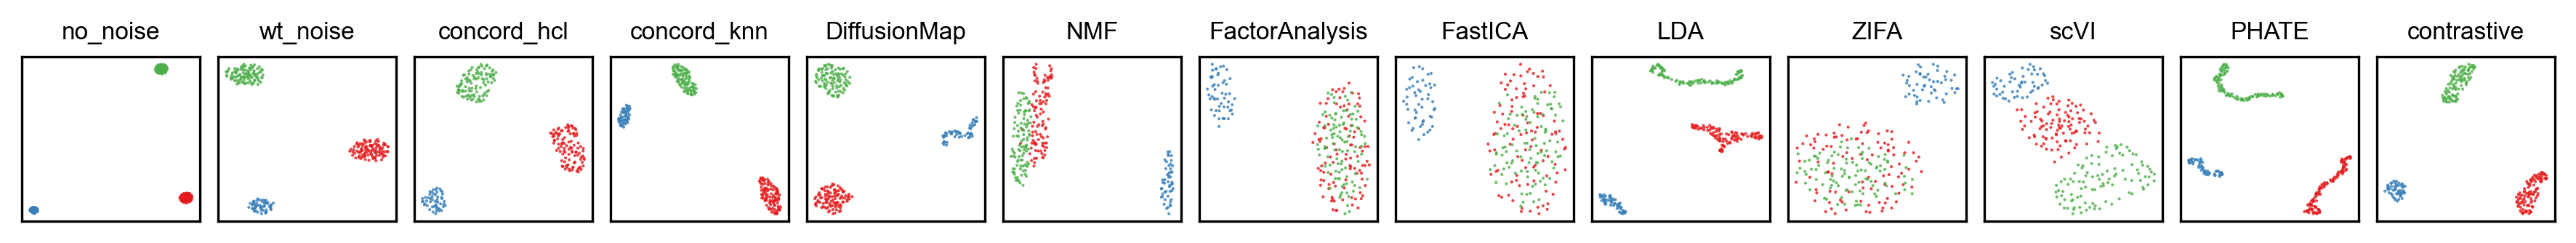

In [55]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = [state_key]
#basis_types = ['', 'PAGA', 'KNN', 'PCA', 'UMAP']
basis_types = ['UMAP']
font_size=8
point_size=4
alpha=0.8
figsize=(0.9*len(combined_keys),1)
ncols = len(combined_keys)
nrows = 1
pal = {'state':'tab10'}
k=15
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        combined_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='svg'
    )


In [51]:
# Find the indices of common genes between `adata` and `adata_state`
# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_knn', path=batch_indices, sigma=2)
adata.obsm['concord_knn_sorted'] = adata.obsm['concord_knn'][:, feature_order]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_hcl', path=batch_indices, sigma=2)
adata.obsm['concord_hcl_sorted'] = adata.obsm['concord_hcl'][:, feature_order]


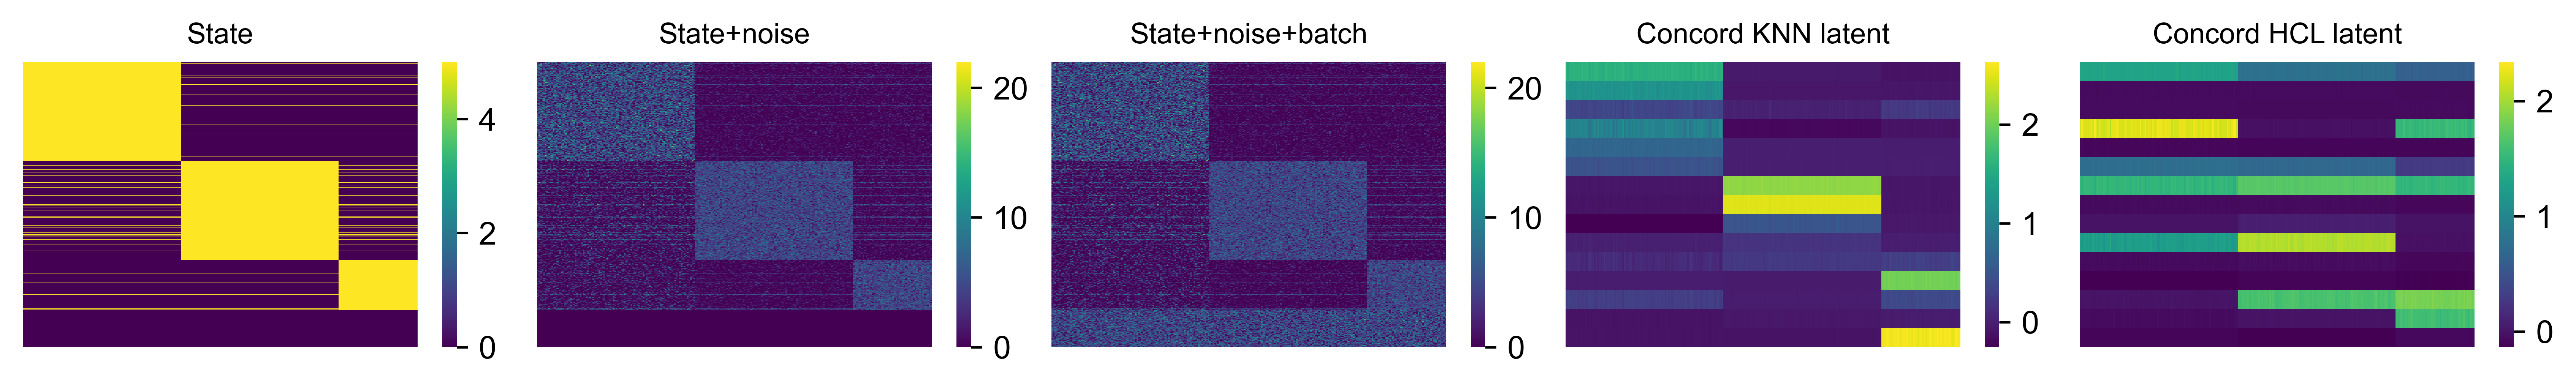

In [57]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
dpi = 600
_, _, state_pal = ccd.pl.get_color_mapping(adata, state_key, pal='tab10', seed=seed)
_, _, batch_pal = ccd.pl.get_color_mapping(adata, batch_key, pal='Set1', seed=seed)
pal = {state_key: state_pal, batch_key: batch_pal}
with plt.rc_context(rc=custom_rc):
    fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
    ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_knn_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord KNN latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_hcl_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord HCL latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    plt.tight_layout(w_pad=0.0, h_pad=0.1)
    plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

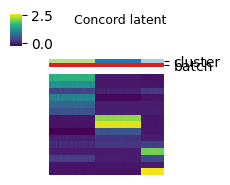

In [98]:
ccd.pl.heatmap_with_annotations(adata, val='concord_knn_sorted', obs_keys=[state_key, batch_key], pal=pal, use_clustermap=True, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=f"heatmap_wt_annot_{file_suffix}.svg", figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)

# Evaluation

In [5]:
adata = sc.read(data_dir / f"adata_Jul18-1519.h5ad")
adata.shape

(250, 2875)

Run topological analysis pipeline:

concord.benchmarking.benchmark - INFO - Running Topology benchmark
concord.benchmarking.benchmark - INFO - Computing persistent homology for no_noise
concord.benchmarking.benchmark - INFO - Computing persistent homology for wt_noise
concord.benchmarking.benchmark - INFO - Computing persistent homology for DiffusionMap
concord.benchmarking.benchmark - INFO - Computing persistent homology for NMF
concord.benchmarking.benchmark - INFO - Computing persistent homology for FactorAnalysis
concord.benchmarking.benchmark - INFO - Computing persistent homology for FastICA
concord.benchmarking.benchmark - INFO - Computing persistent homology for LDA
concord.benchmarking.benchmark - INFO - Computing persistent homology for ZIFA
concord.benchmarking.benchmark - INFO - Computing persistent homology for scVI
concord.benchmarking.benchmark - INFO - Computing persistent homology for PHATE
concord.benchmarking.benchmark - INFO - Computing persistent homology for concord_hcl
concord.benchmarking.benchmar

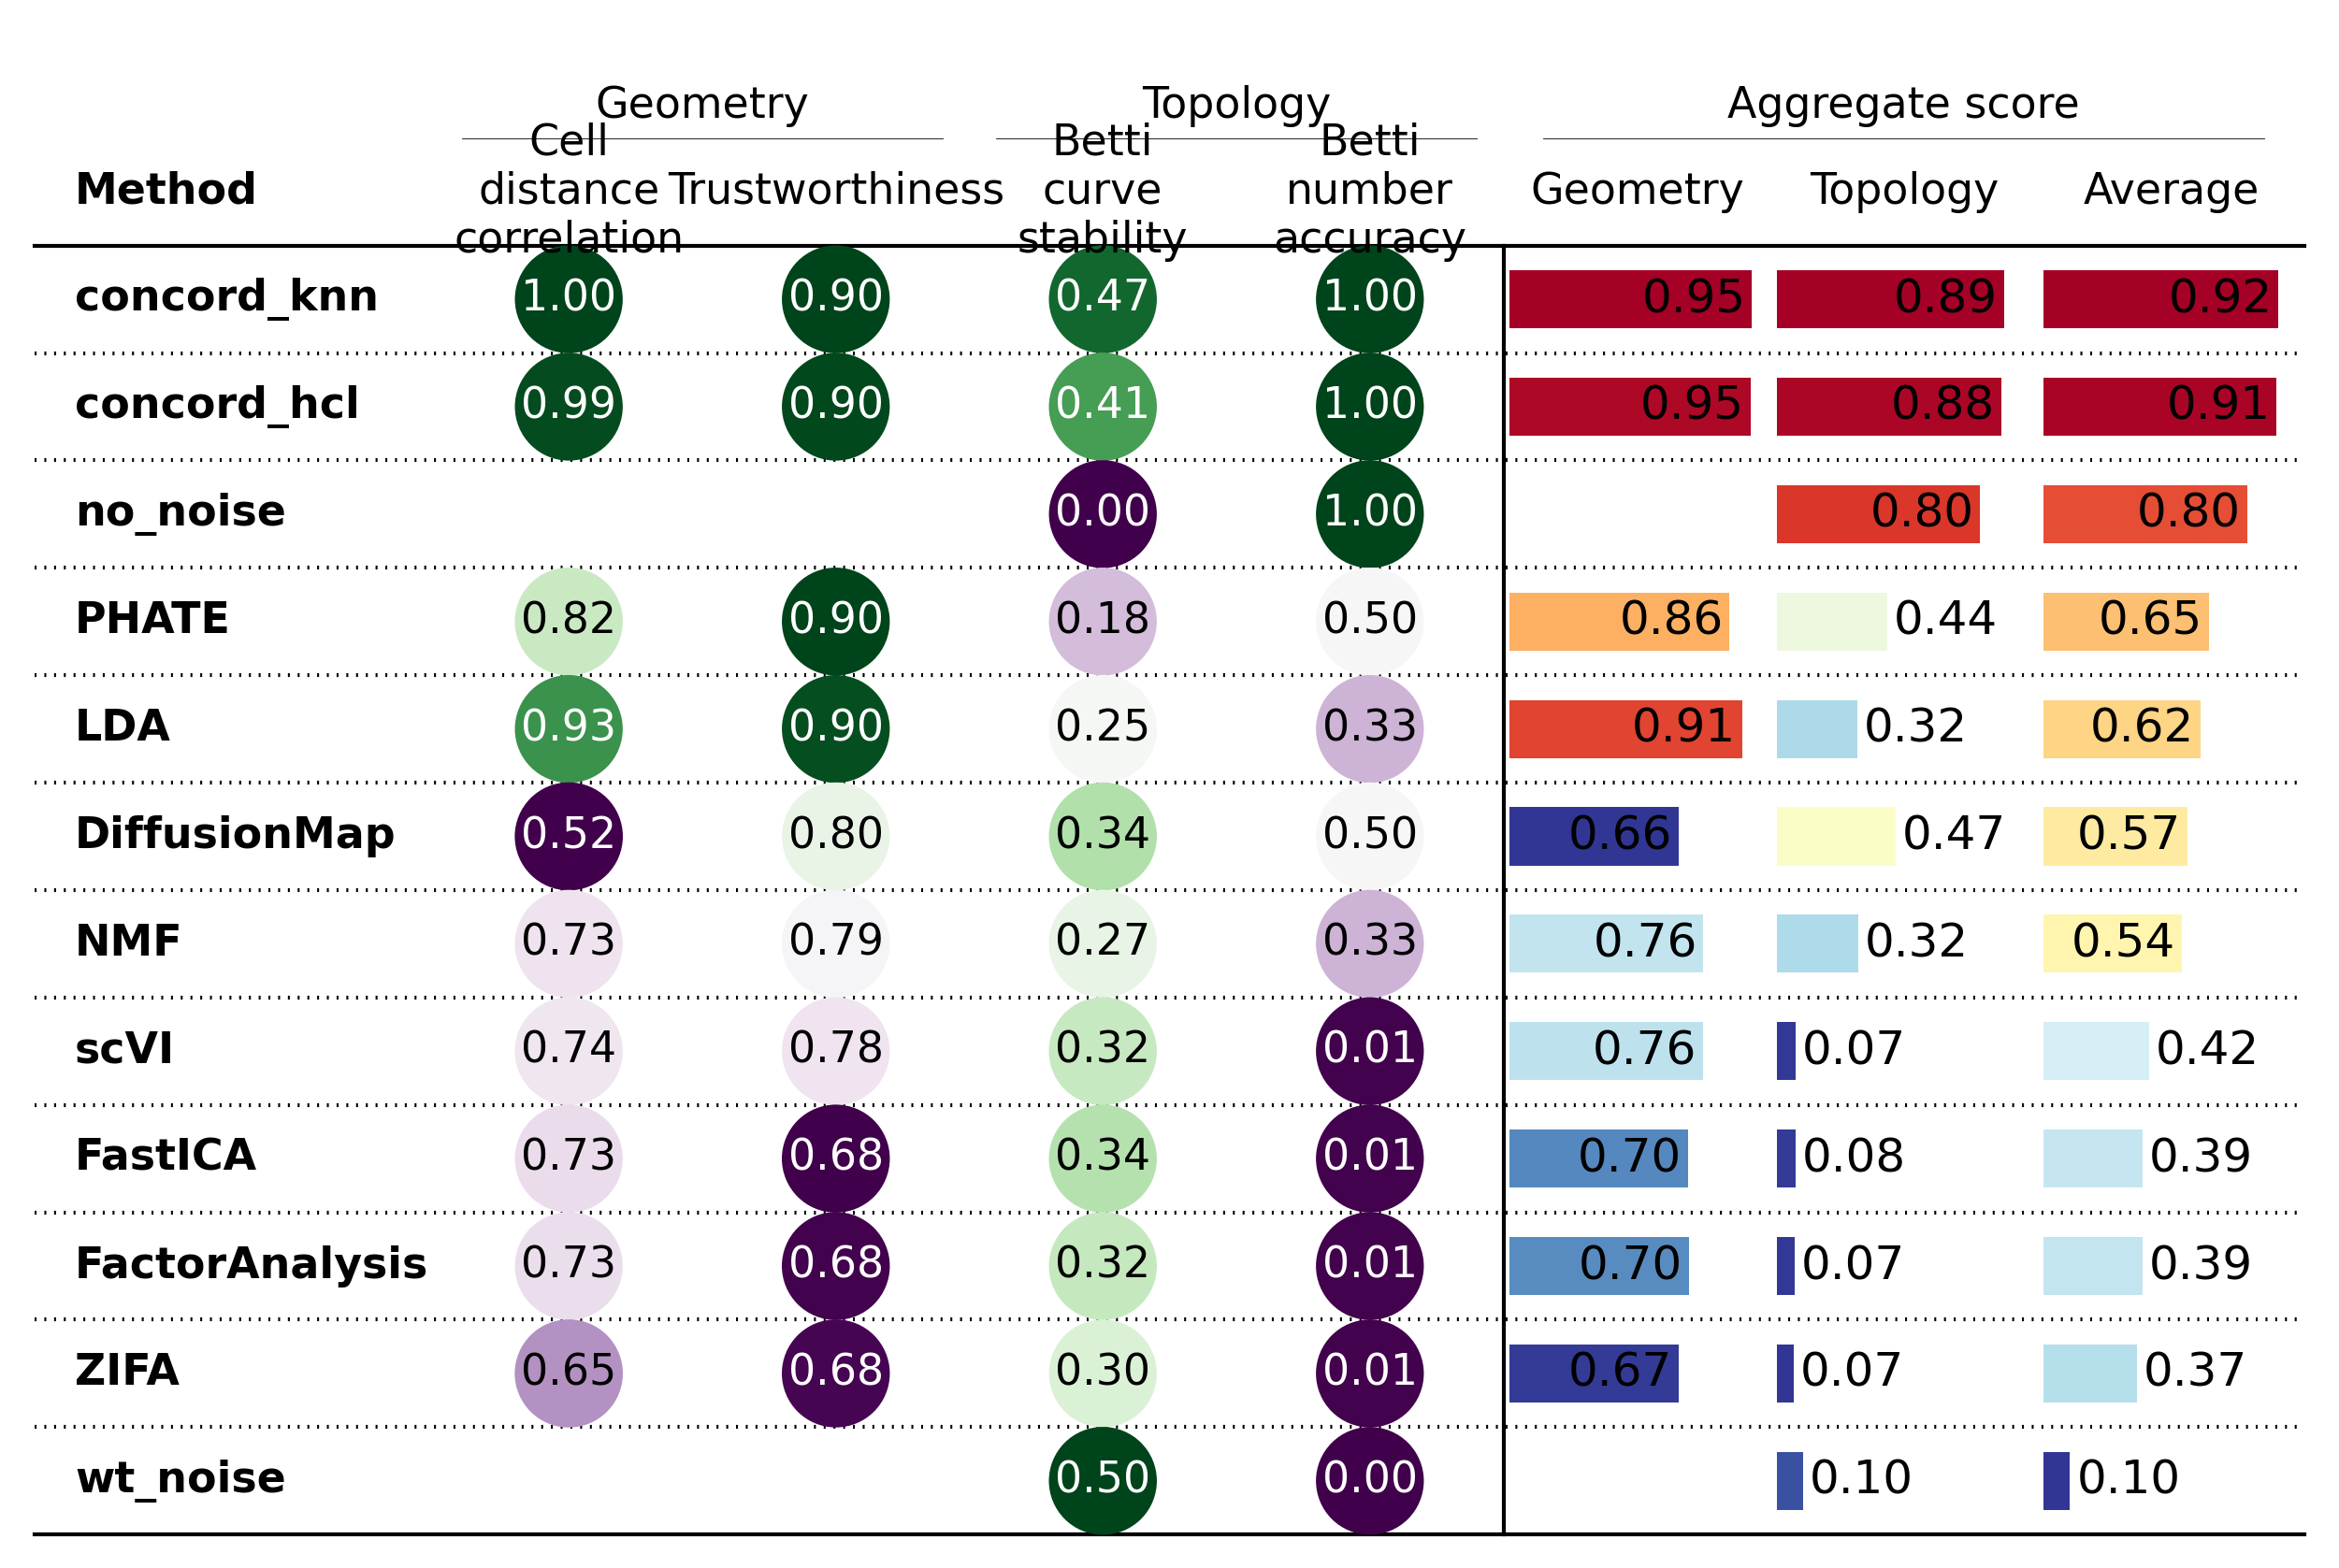

concord.benchmarking.benchmark - INFO - Saved benchmark results to ../save/dev_simulation_clustereasy_singlebatch-Jul19/benchmarks_out/benchmark_results_Jul19-2134.pkl


Geometry                              Topology  \
            Cell distance correlation Trustworthiness Betti curve stability   
concord_knn                  0.999588        0.904714              0.466927   
concord_hcl                  0.991434        0.902612              0.414662   
no_noise                          NaN             NaN              0.000839   
PHATE                        0.824926        0.904690              0.175293   
LDA                          0.927448        0.899788              0.253044   

                                  Aggregate score                      
            Betti number accuracy        Geometry  Topology   Average  
concord_knn              1.000000        0.952151  0.893385  0.922768  
concord_hcl              1.000000        0.947023  0.882932  0.914978  
no_noise                 1.000000             NaN  0.800168  0.800168  
PHATE                    0.500000        0.864808  0.435059  0.649933  
LDA                      0.333333        0.913618  0.317276  0.615447

In [ ]:
clean_keys = [k for k in combined_keys if k not in {"contrastive"}]
# put concord keys at the end of the list
# clean_keys = [k for k in clean_keys if k not in concord_methods] + concord_methods

out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=clean_keys,
    state_key=state_key,
    batch_key=batch_key,
    groundtruth_key="no_noise",  # use the Leiden clusters as ground truth
    save_dir=save_dir / "benchmarks_out",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("topology", "geometry"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
    expected_betti_numbers = [2,0,0]
)
combined = out["combined"]
combined.head()

In [30]:
len(combined.columns)

7

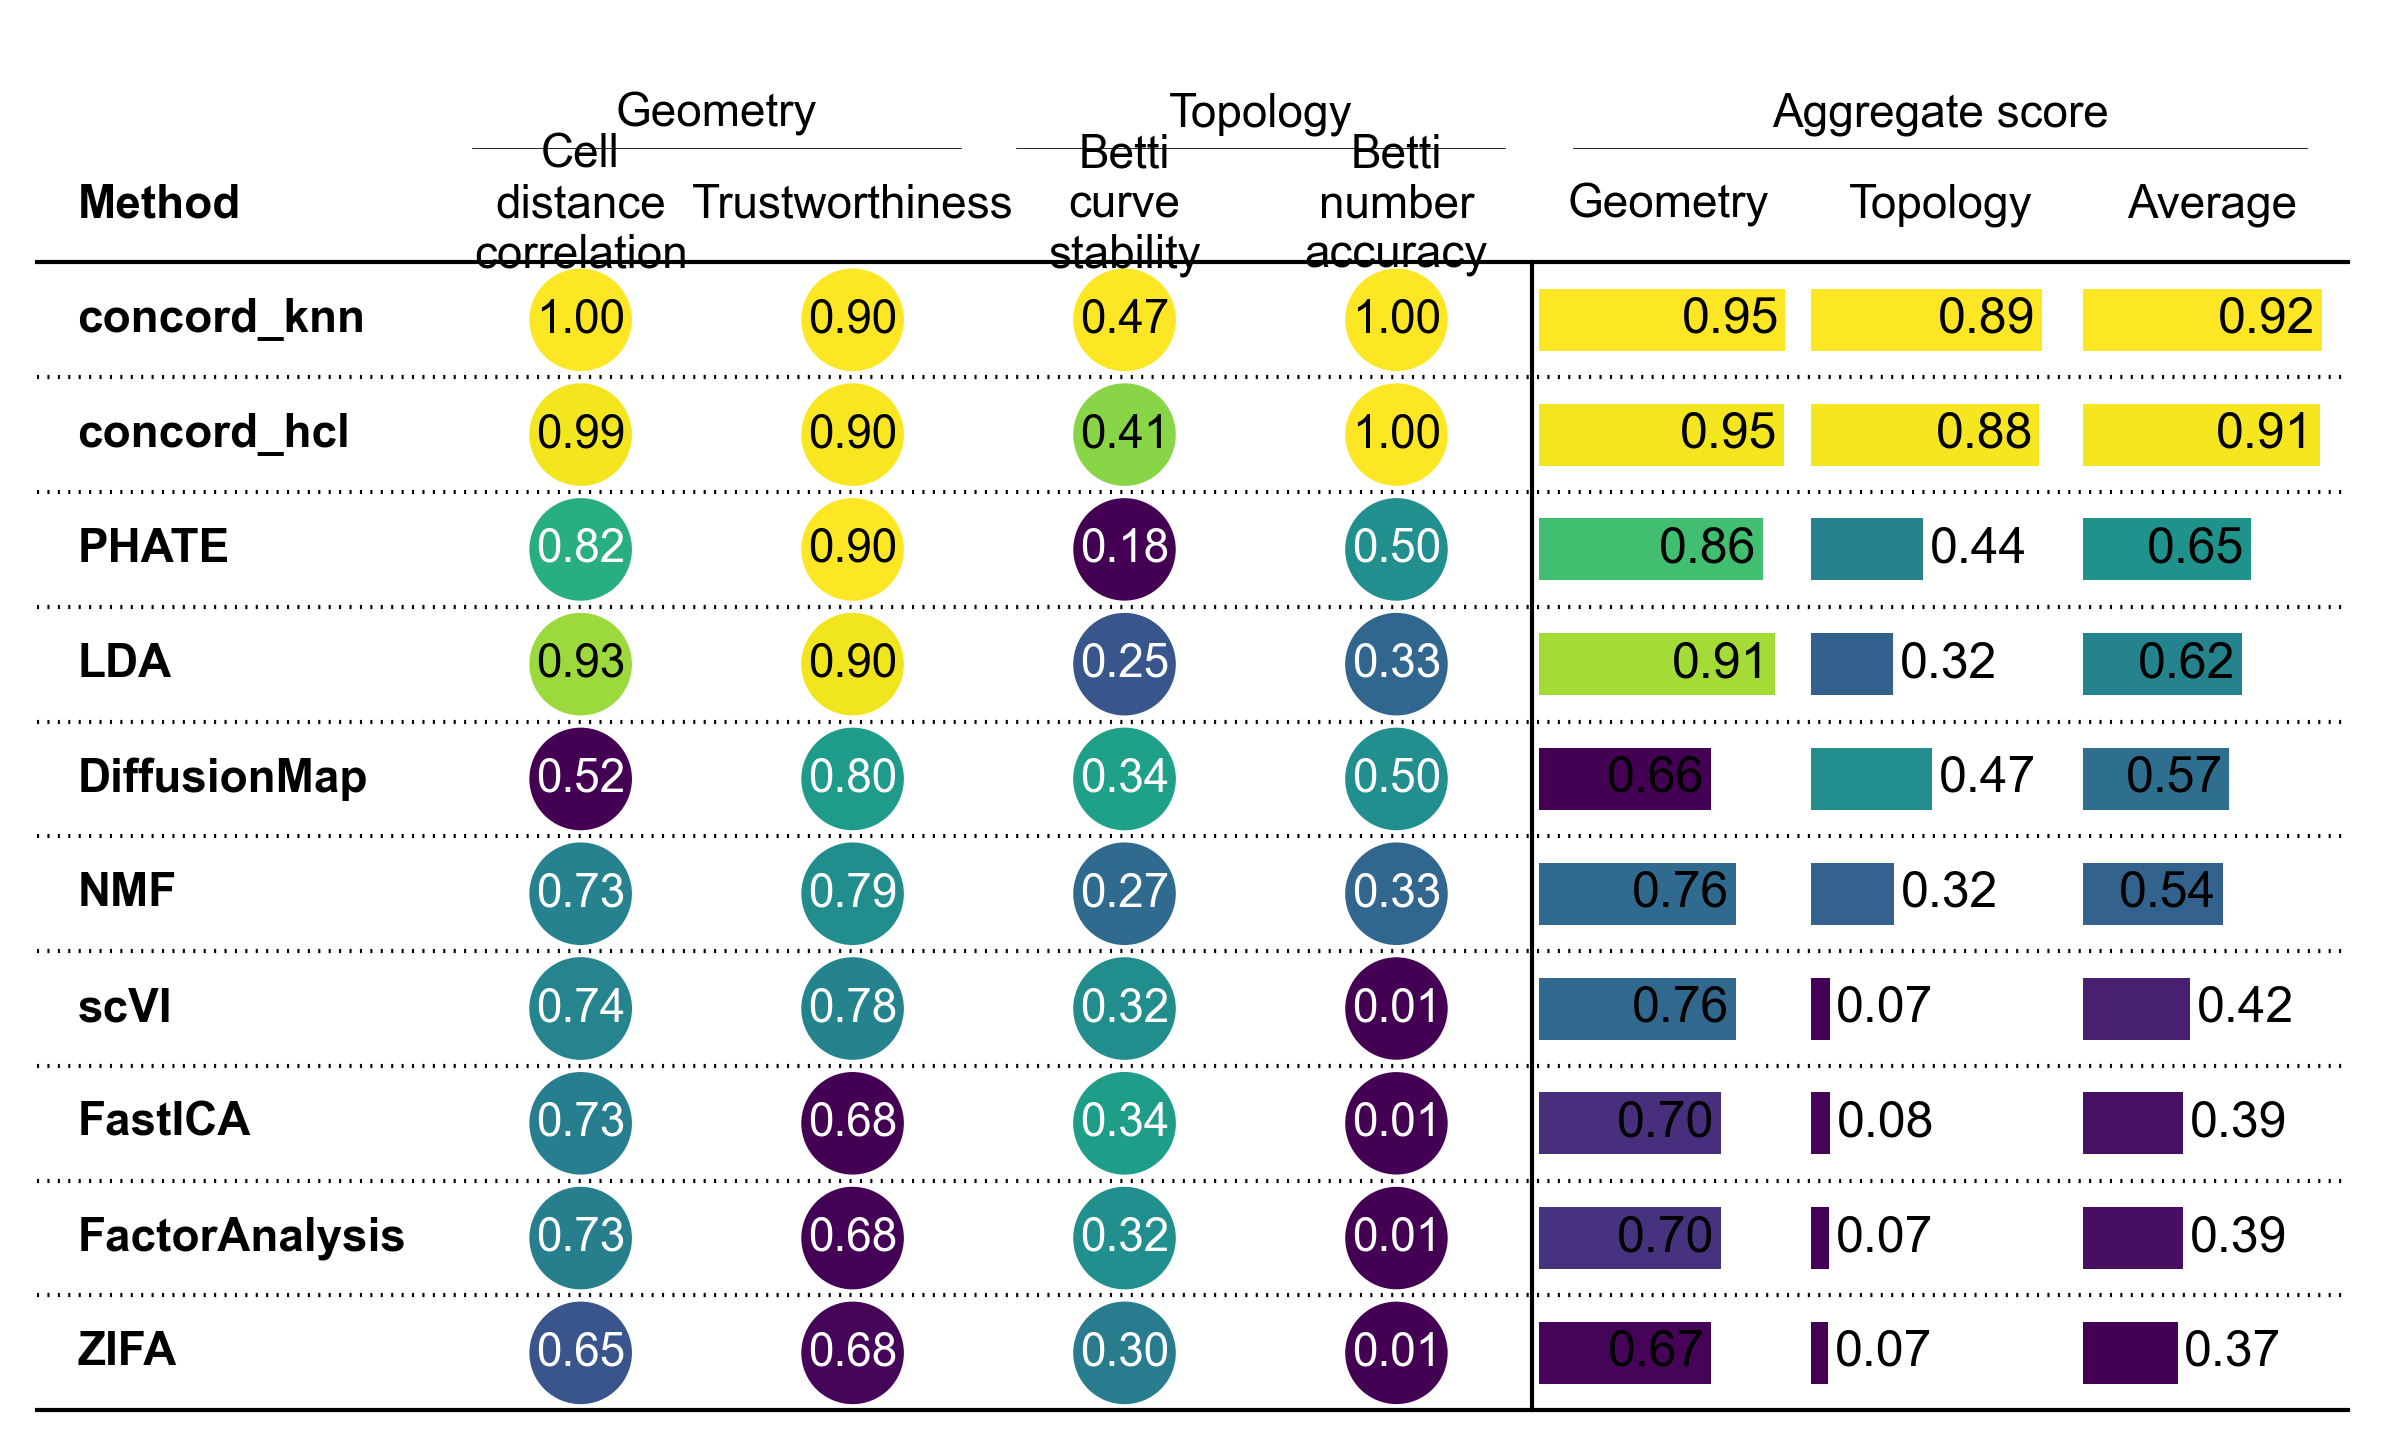

In [47]:
table_plot_kw = dict(
        pal="viridis", pal_agg="viridis", cmap_method="minmax", dpi=300)
with plt.rc_context(rc=custom_rc):
        ccd.bm.plot_benchmark_table(
                combined.dropna(axis=0, how='any'),
                save_path=save_dir / f"benchmark_table_{file_suffix}.svg",
                agg_name="Aggregate score",
                figsize=(10, 6),
                **table_plot_kw
                )

In [19]:
import pickle
with open(Path('../save/dev_simulation_clustereasy_singlebatch-Jul18/benchmarks_out/topology_diagrams_Jul18-2041.pkl'), 'rb') as f:
    diagrams = pickle.load(f)

geometry_full = pickle.load(open('../save/dev_simulation_clustereasy_singlebatch-Jul18/benchmarks_out/geometry_results_Jul18-2041.pkl', 'rb'))


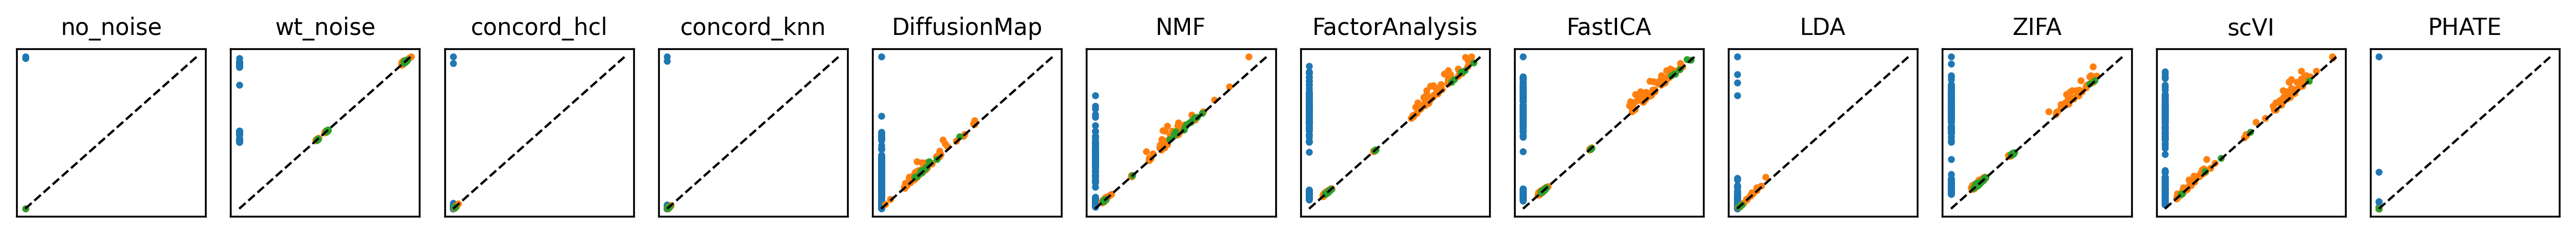

In [16]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in clean_keys if key in diagrams}
# Change the key names to remove 'PCA_'
diagrams_ordered = {key.replace('_PCA', ''): diagrams_ordered[key] for key in diagrams_ordered}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=12, fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.svg", legend=False, label_axes=False, axis_ticks=False)

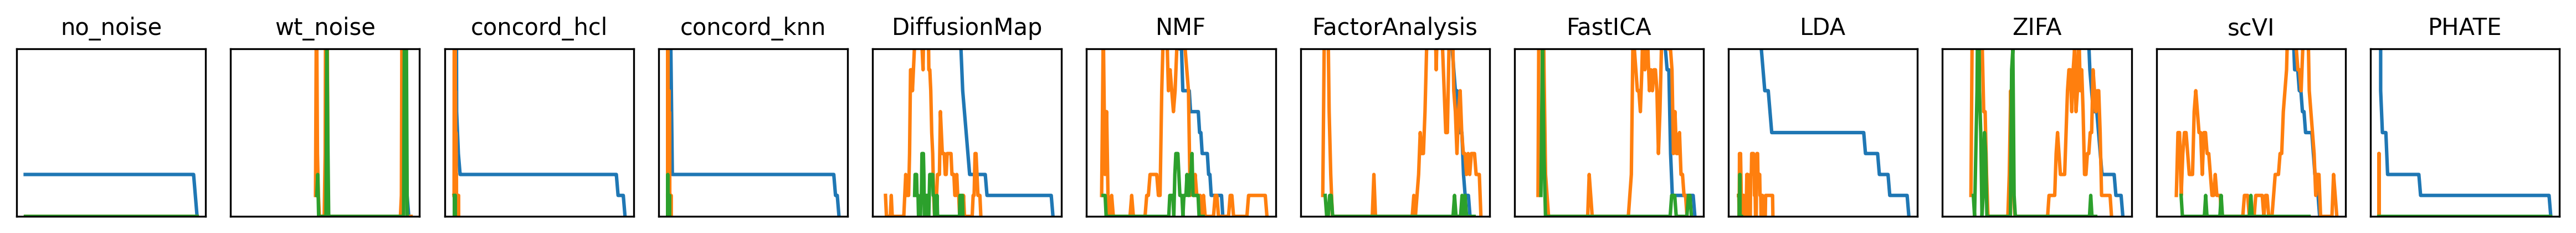

In [17]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=12, fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

In [20]:
geometry_full['cell_distance_corr']['distance']

{'no_noise': array([1.11022302e-16, 1.11022302e-16, 1.11022302e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'wt_noise': array([0.41891829, 0.43090547, 0.42452424, ..., 0.23703351, 0.23173358,
        0.24003689]),
 'DiffusionMap': array([0.65056681, 0.25260244, 1.16988087, ..., 0.10540831, 0.13772559,
        0.00229572]),
 'NMF': array([0.8220737 , 0.96212722, 0.8890232 , ..., 0.11335564, 0.07598361,
        0.06773885]),
 'FactorAnalysis': array([0.79306747, 1.35174981, 0.81811482, ..., 0.06783108, 0.05359442,
        0.05918461]),
 'FastICA': array([0.73470647, 1.01439944, 1.16206309, ..., 0.10702906, 0.06426792,
        0.12656289]),
 'LDA': array([7.85010052e-02, 1.65395428e-01, 3.26192043e-01, ...,
        1.97219623e-04, 1.66966502e-04, 3.92619985e-05]),
 'ZIFA': array([1.01437064, 1.19323857, 0.68338883, ..., 0.34877016, 0.19015255,
        0.32196431]),
 'scVI': array([1.17914591, 0.99185902, 0.71307065, ..., 0.40467211, 0.52527912,
        0.15164748])

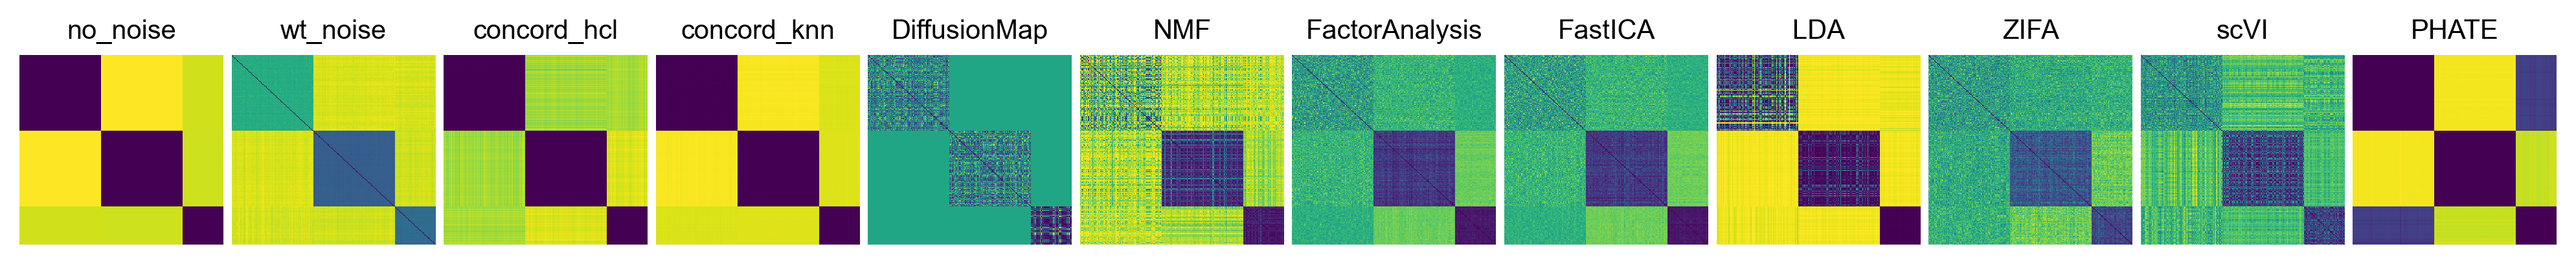

In [24]:
import pandas as pd

# Collect the distances for each key in clean_keys
geometry_distance_ordered = pd.DataFrame({key: geometry_full['cell_distance_corr']['distance'][key] for key in clean_keys})

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_distance_heatmap(geometry_distance_ordered, n_cols=12, figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.svg")

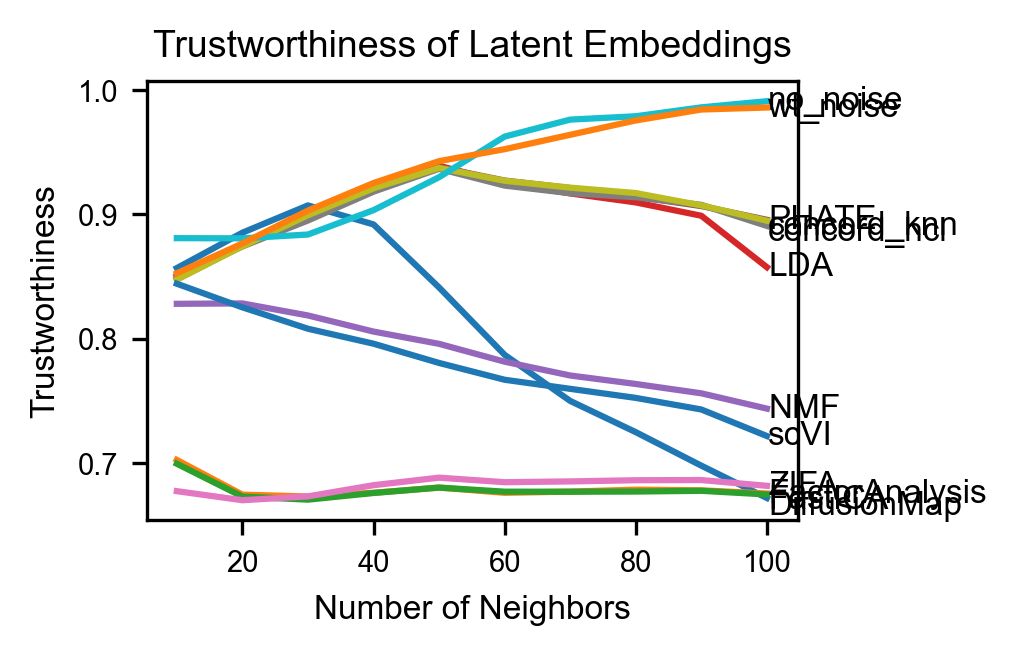

In [73]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
drop_methods = []
# Drop row with column 'Embedding' in drop_methods
trustworthiness_scores = trustworthiness_scores[~trustworthiness_scores['Embedding'].isin(drop_methods)]
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=0.2, min_gap=0.005, legend=False, save_path=save_dir / f"trustworthiness_{file_suffix}.pdf", figsize=(2.8,1.9))